In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
time0 = time.perf_counter()
timeF = time.perf_counter()
print(timeF - time0)

###################### Inisiasi ###################
file = 'DTVir'
t = np.loadtxt(file+'.txt',usecols=0)
m = np.loadtxt(file+'.txt', usecols=1)

3.105192445218563e-05


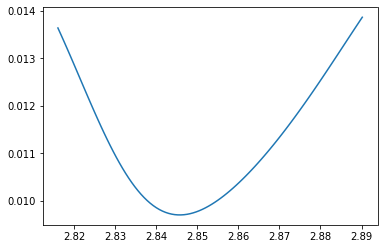

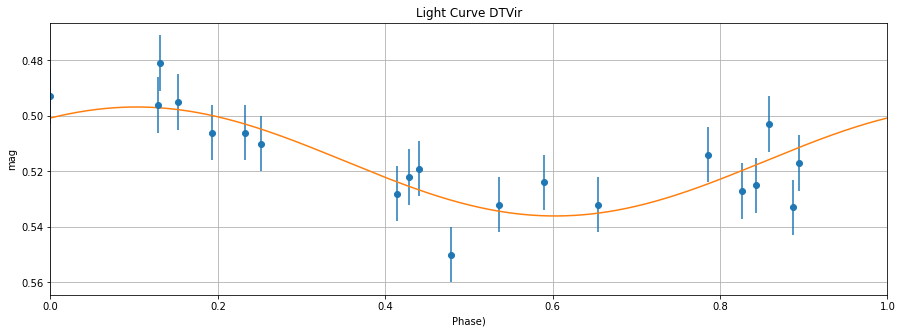

In [3]:
def light_curve(phase, mean, amplitude, phase0):
    return amplitude*np.sin(phase*2*np.pi+phase0*2*np.pi)+mean

phase = np.linspace(0,1,1000)
Period = 2.846264
phase0 = 0.65
amplitude = 0.02
mean = 0.51
fase = (t-t[0])/Period - (t-t[0])//Period
popt, pcov = curve_fit(light_curve, fase, m, p0=(mean, amplitude, phase0))

magnitude = light_curve(phase, popt[0], popt[1], popt[2])

sigma_B = 0.01

plt.figure(0,figsize=(15,5))
plt.errorbar(fase, m, yerr=sigma_B, fmt='o')
plt.plot(phase, magnitude)
plt.xlabel('Phase)')
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title('Light Curve %s'%file)
plt.grid(True)
plt.show()

In [4]:
from scipy.stats import norm
from scipy.stats import beta

def log_likelihood(y, ymod, sigma):
    return -1/(2*sigma**2)*np.sum((ymod-y)**2)+len(y)/(2*sigma**2)*np.log(1/(sigma*np.sqrt(2*np.pi)))

def log_prior_period(T, Tmin, Tmax):
    Tbeta = (T-Tmin)/(Tmax-Tmin)
    return np.log(beta.pdf(Tbeta,2,2))

def log_prior_phase(phase):
    return np.log(1/(2*np.pi))

def log_prior_amplitude(amplitude, amp_min=0.1, amp_max=1):
    return np.log(1/(amp_max-amp_min))

def log_prior_amplitude(mean, mean_min=0.1, mean_max=1):
    return np.log(1/(mean_max-mean_min))


def log_posterior(T, Tmin, Tmax, amplitude, amp_min, amp_max, mean, phase0, x, y, sigma):
    ymod = amplitude*np.sin(2*np.pi*x + 2*np.pi*phase0) + mean
    return log_likelihood(y, ymod, sigma) + log_prior_period(T, Tmin, Tmax) + log_prior_phase(x) + log_prior_amplitude(amplitude, amp_min, amp_max)

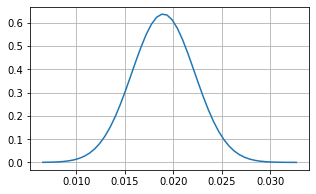

1193.1726484500105


In [6]:
# T = P
time0 = time.perf_counter()

Period = 2.846264
mean = 0.5164279668526047
phase0 =  0.6471063467976546
amplitude =  0.019627767832892613
P = np.linspace(2.825, 2.875, 50)
means = np.linspace(0.5075, 0.525, 50)
phases = np.linspace(0.4, 0.9, 50)
amplitudes = np.linspace(amplitude -amplitude/1.5, amplitude + amplitude/1.5, 50)
amp_min, amp_max = amplitudes[0], amplitudes[-1] 
# P = [Period]
# means = [mean]
# phases = [phase0]

Tmin, Tmax = P[0]*0.99, P[-1]*1.01
sigma = 0.01
y = m
Post = np.zeros((len(P), len(means), len(phases), len(amplitudes)))
for i in range(len(P)):
    T = P[i]
    x = (t-t[0])/T - (t-t[0])//T
    for j in range(len(means)):
        mean = means[j]
        for k in range(len(phases)):
            phase0 = phases[k]
            for l in range(len(amplitudes)):
                amplitude = amplitudes[l]
                Post[i, j, k, l] = log_posterior(T, Tmin, Tmax, amplitude, amp_min, amp_max, mean, phase0, x, y, sigma)
Post -= np.max(Post)
POST = np.exp(Post[25,25,25])
plt.figure(figsize=(5,3))
plt.plot(amplitudes, POST)
plt.grid()
plt.show()
timeF = time.perf_counter()
print(timeF - time0)

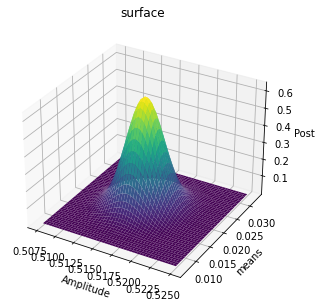

In [7]:
from mpl_toolkits import mplot3d

# X, Y = np.meshgrid(P, means)
X, Y = np.meshgrid(means, amplitudes)
Z = np.exp(Post[25,:,25,:])
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Post, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_title('surface');
ax.set_ylabel('means')
# ax.set_xlabel('Mean');
ax.set_xlabel('Amplitude');
ax.set_zlabel('Post');

In [49]:
phases = np.linspace(0.4, 0.9, 50)
Post_Phases = np.sum(np.exp(Post), axis=(0,1,3))
popt, pcov = curve_fit(normal, phases, Post_Phases, p0=(phase0, 0.1, 1))
sigma_Phase = popt[1]
phase0 = popt[0]
Area, _ = quad(normal, phase0-sigma_Phase*5, phase0+sigma_Phase*5, args=(phase0, sigma_Phase, popt[2]))
Post_Phases /= Area

Period =  2.8469478313983787
0.007901285082098733


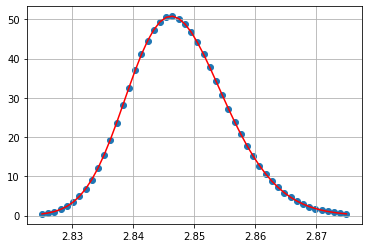

mean =  0.5164164118675445
0.0022603200826997838


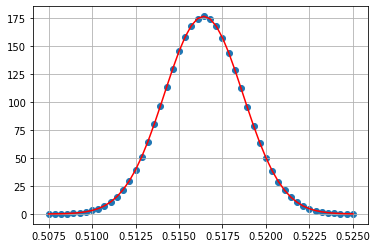

Phase0 =  0.6448831609620157
0.05774342141428263


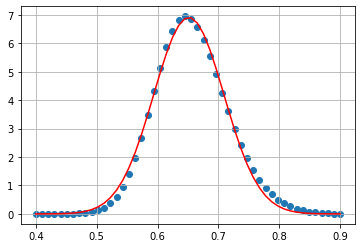

Amplitude =  0.018957108767949832
0.003430842636014363


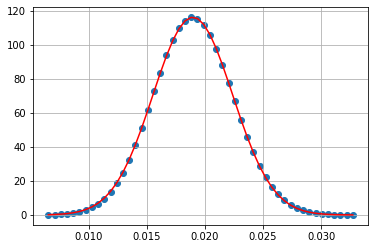

In [51]:
from scipy.integrate import simps
from scipy.integrate import quad

from scipy.stats import norm
def normal(x, loc=0, scale=1, normalization=1):
    return normalization*norm.pdf(x, loc=loc, scale=scale)

Post_P = np.sum(np.exp(Post), axis=(1,2,3))
popt, pcov = curve_fit(normal, P, Post_P, p0=(Period, 0.1, 1))
sigma_P = popt[1]
Period = popt[0]
Area, _ = quad(normal, Period-sigma_P*3, Period+sigma_P*3, args=(Period, sigma_P, popt[2]))
Post_P /= Area
Post_P_mod = normal(P, loc=Period, scale=1)

Post_mean = np.sum(np.exp(Post), axis=(0,2,3))
popt, pcov = curve_fit(normal, means, Post_mean, p0=(mean, 0.05, 1))
sigma_mean = popt[1]
mean = popt[0]
Area, _ = quad(normal, mean-sigma_mean*5, mean+sigma_mean*5, args=(mean, sigma_mean, popt[2]))
Post_mean /= Area
Post_mean_mod = normal(means, loc=mean, scale=sigma_mean, normalization=1)

phases = np.linspace(0.4, 0.9, 50)
Post_Phases = np.sum(np.exp(Post), axis=(0,1,3))
popt, pcov = curve_fit(normal, phases, Post_Phases, p0=(phase0, 0.1, 1))
sigma_Phase = popt[1]
phase0 = popt[0]
Area, _ = quad(normal, phase0-sigma_Phase*5, phase0+sigma_Phase*5, args=(phase0, sigma_Phase, popt[2]))
Post_Phases /= Area
Post_Phases_mod = normal(phases, loc=phase0, scale=sigma_Phase, normalization=1)

Post_Amplitude = np.sum(np.exp(Post), axis=(0,1,2))
popt, pcov = curve_fit(normal, amplitudes, Post_Amplitude, p0=(0.1, 0.05, 1))
sigma_Amplitude = popt[1]
amplitude = popt[0]
Area, _ = quad(normal, amplitude-sigma_Amplitude*5, amplitude+sigma_Amplitude*5, args=(amplitude, sigma_Amplitude, popt[2]))
Post_Amplitude /= Area
Post_Amplitude_mod = normal(amplitudes, loc=amplitude, scale=sigma_Amplitude, normalization=1)

# Post_P -= np.max(Post_P)
print('Period = ', Period)
print(sigma_P)
plt.figure()
plt.scatter(P, Post_P)
plt.plot(P, Post_P, c='r')
plt.grid()
plt.show()

print('mean = ', mean)
print(sigma_mean)
plt.figure()
plt.scatter(means, Post_mean)
plt.plot(means, Post_mean_mod, c='r')
plt.grid()
plt.show()

print('Phase0 = ', phase_0)
print(sigma_Phase)
plt.figure()
plt.scatter(phases, Post_Phases)
plt.plot(phases, Post_Phases_mod, c='r')
plt.grid()
plt.show()

print('Amplitude = ', amplitude)
print(sigma_Amplitude)
plt.figure()
plt.scatter(amplitudes, Post_Amplitude)
plt.plot(amplitudes, Post_Amplitude_mod, c='r')
plt.grid()
plt.show()

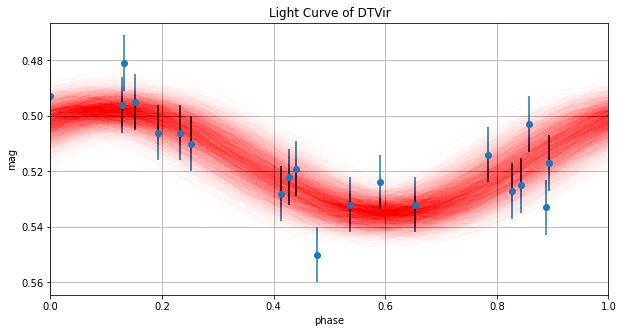

In [63]:
sigma_B = 0.01
Period = 2.846264
mean = 0.5164279668526047
phase0 =  0.6471063467976546
amplitude =  0.019627767832892613

phases = np.linspace(0, 1, 100)
plt.figure(figsize=(10,5))
plt.errorbar(fase, m, yerr=sigma_B, fmt='o')
fase = (t-t[0])/Period - (t-t[0])//Period
for i in range(5000):
    P_mod = np.random.normal(loc=Period, scale=sigma_P)
    mean_mod = np.random.normal(loc=mean, scale=sigma_mean)
    phase0_mod = np.random.normal(loc=phase0, scale=sigma_Phase)
    amplitude_mod = np.random.normal(loc=amplitude, scale=sigma_Amplitude)
    m_mod = amplitude_mod*np.sin(2*np.pi*phases+2*np.pi*phase0_mod)+mean_mod
    plt.plot(phases, m_mod, c='r', alpha=0.003)
plt.xlabel('phase')
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title('Light Curve of %s'%file)
plt.grid(True)
plt.savefig('LightCurve.png', dpi=70)
plt.show()